In [1]:
!pip install scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import glob as gb
import PIL   #pillow
#pip install pillow
from keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications.vgg19 import VGG19
import tensorflow as tf
import pickle
from keras.layers import Dense, Conv2D, MaxPooling2D, AvgPool2D, Input, Dropout, Flatten, BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.regularizers import l2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sign/labels.csv')


In [4]:
new_size=224    

X = []
y = []
for i in range(len(data)):
    img_path = '/content/drive/MyDrive/Colab Notebooks/sign/images/' + data['image_name'][i]
    orignal_image = cv2.imread(img_path)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image , (new_size,new_size))
  
    X.append(resized_image)
    y.append(data['label_name'][i])

In [5]:
label_dict = {k: v for v, k in enumerate(set(y))}
y = [label_dict[label] for label in y]

In [6]:
reverse_label_dict = {v: k for k, v in label_dict.items()}
original_labels = [reverse_label_dict[label_index] for label_index in y]
label_dict.items()

dict_items([('month', 0), ('granfather', 1), ('drink', 2), ('zero', 3), ('sorry', 4), ('mother', 5), ('sleep', 6), ('father', 7), ('eat', 8), ('today', 9)])

In [7]:
X = np.array(X)
y = np.array(y, dtype=np.int32)
from tensorflow.keras.utils import to_categorical
y=to_categorical(y,10)
from sklearn.utils import shuffle
X,y = shuffle(X,y)
X=X/255.0
df = pd.DataFrame(list(zip(X, y)), columns =['images', 'label']) 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)



In [19]:
from keras.preprocessing.image import ImageDataGenerator

# Define an image data generator with augmentation options
augmenter = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

# Load your dataset into a generator
#val_generator = ImageDataGenerator().flow(X_test, y_test, batch_size=32)



In [21]:
train_generator = augmenter.flow(X_train, y_train)
val_generator = augmenter.flow(X_test, y_test)



In [10]:
vgg = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
flat_layer = Flatten()(vgg.output)
final_layer = Dense(10, activation='softmax')(flat_layer)
model = Model(inputs=vgg.input, outputs=final_layer)
model.summary()


80134624/80134624 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
earlystop = EarlyStopping("val_accuracy", patience=30, verbose=1, restore_best_weights=True,)

model.fit(train_generator, epochs=100,validation_data=val_generator,callbacks=[earlystop])


Epoch 1/100
5/5 [==============================] - 3s 527ms/step - loss: 1.5754 - accuracy: 0.5897 - val_loss: 2.4326 - val_accuracy: 0.4103
Epoch 2/100
5/5 [==============================] - 2s 434ms/step - loss: 1.5777 - accuracy: 0.5962 - val_loss: 1.3438 - val_accuracy: 0.5897
Epoch 3/100
5/5 [==============================] - 2s 447ms/step - loss: 1.0637 - accuracy: 0.6218 - val_loss: 0.7321 - val_accuracy: 0.7179
Epoch 4/100
5/5 [==============================] - 2s 425ms/step - loss: 0.8209 - accuracy: 0.7436 - val_loss: 0.5824 - val_accuracy: 0.8205
Epoch 5/100
5/5 [==============================] - 2s 476ms/step - loss: 0.7627 - accuracy: 0.7821 - val_loss: 0.8391 - val_accuracy: 0.7436
Epoch 6/100
5/5 [==============================] - 2s 429ms/step - loss: 0.7109 - accuracy: 0.7885 - val_loss: 0.5523 - val_accuracy: 0.8462
Epoch 7/100
5/5 [==============================] - 2s 436ms/step - loss: 0.6703 - accuracy: 0.7949 - val_loss: 0.5076 - val_accuracy: 0.8974
Epoch 8/100
5

In [24]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/Colab Notebooks/sign/images/sign.h5')

scores=model.evaluate(X_test,y_test)
print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))



2/2 [==============================] - 0s 80ms/step - loss: 0.0321 - accuracy: 1.0000
Accuarcy accuracy: 100.00%


In [ ]:
y_test_pred = model.predict(X_test)
y_prediction = np.argmax(y_test_pred, axis=1)
y_true=np.argmax(y_test, axis=1)

1/1 [==============================] - 3s 3s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(y_true, y_prediction)
cm

array([[2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2]])

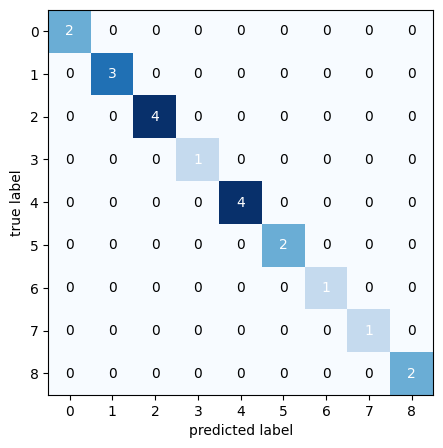

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         6
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         1

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [ ]:
predictions = model.predict(X_test)

# Get the index of the predicted label
predicted_label_index = tf.argmax(predictions, axis=-1).numpy()[0]

# Output the predicted label
print(f"Predicted label: {predicted_label_index}")

1/1 [==============================] - 0s 40ms/step
Predicted label: 5


In [29]:
z=[]
img_path = '/content/drive/MyDrive/Colab Notebooks/sign/1.jpg' 
orignal_image = cv2.imread(img_path)
image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (224,224))
z.append(resized_image)
z= np.array(z)
z=z/255.0

In [30]:
predictions = model.predict(z)

# Get the index of the predicted label
predicted_label_index = tf.argmax(predictions, axis=-1).numpy()[0]

# Output the predicted label
print(f"Predicted label: {predicted_label_index}")

1/1 [==============================] - 0s 19ms/step
Predicted label: 7


In [31]:
#dict_items([('month', 0), ('granfather', 1), ('drink', 2), ('zero', 3), ('sorry', 4), ('mother', 5), ('sleep', 6), ('father', 7), ('eat', 8), ('today', 9)])
